In [1]:
import os
cur_dir = os. getcwd()
print(cur_dir)

d:\CellSeg


In [2]:
!pip install csbdeep
!pip install stardist
!pip install monai
!pip install timm

In [ ]:

import os
join = os.path.join
import argparse
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision import datasets, models, transforms
from classifiers import resnet10, resnet18

from utils_modify import sliding_window_inference,sliding_window_inference_large,__proc_np_hv
from PIL import Image
import torch.nn.functional as F
from skimage import io, segmentation, morphology, measure, exposure
import tifffile as tif
from models.flexible_unet_convnext import FlexibleUNet_star,FlexibleUNet_hv
#from overlay import visualize_instances_map

def normalize_channel(img, lower=1, upper=99):
    non_zero_vals = img[np.nonzero(img)]
    percentiles = np.percentile(non_zero_vals, [lower, upper])
    if percentiles[1] - percentiles[0] > 0.001:
        img_norm = exposure.rescale_intensity(img, in_range=(percentiles[0], percentiles[1]), out_range='uint8')
    else:
        img_norm = img
    return img_norm.astype(np.uint8)
#torch.cuda.synchronize()
parser = argparse.ArgumentParser('Baseline for Microscopy image segmentation', add_help=False)
# Dataset parameters
parser.add_argument('-i', '--input_path', default='./images', type=str, help='training data path; subfolders: images, labels')
parser.add_argument("-o", '--output_path', default='./outputs', type=str, help='output path')
parser.add_argument('--model_path', default='./models', help='path where to save models and segmentation results')
parser.add_argument('--show_overlay', required=False, default=False, action="store_true", help='save segmentation overlay')
parser.add_argument('-f')
# Model parameters
parser.add_argument('--model_name', default='efficientunet', help='select mode: unet, unetr, swinunetr')
parser.add_argument('--input_size', default=512, type=int, help='segmentation classes')
args = parser.parse_args()
input_path = args.input_path
output_path = args.output_path
model_path = args.model_path
os.makedirs(output_path, exist_ok=True)
#overlay_path = 'overlays/'
#print(input_path)

img_names = sorted(os.listdir(join(input_path)))
#print(img_names)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


preprocess=transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
roi_size = (512, 512)
overlap = 0.5
np_thres, ksize, overall_thres, obj_size_thres = 0.6, 15, 0.4, 100
n_rays = 32
sw_batch_size = 4
num_classes= 4
block_size = 2048
min_overlap = 128
context = 128
with torch.no_grad():
    for img_name in img_names:
        #print(img_name)
        if img_name.endswith('.tif') or img_name.endswith('.tiff'):
            img_data = tif.imread(join(input_path, img_name))
        else:
            img_data = io.imread(join(input_path, img_name))
        # normalize image data
        if len(img_data.shape) == 2:
            img_data = np.repeat(np.expand_dims(img_data, axis=-1), 3, axis=-1)
        elif len(img_data.shape) == 3 and img_data.shape[-1] > 3:
            img_data = img_data[:,:, :3]
        else:
            pass
        pre_img_data = np.zeros(img_data.shape, dtype=np.uint8)
        for i in range(3):
            img_channel_i = img_data[:,:,i]
            if len(img_channel_i[np.nonzero(img_channel_i)])>0:
                pre_img_data[:,:,i] = normalize_channel(img_channel_i, lower=1, upper=99)
        inputs=preprocess(Image.fromarray(pre_img_data)).unsqueeze(0).to(device)
        cls_MODEL = model_path + '/cls/resnet18_4class_all_modified.tar'
        model = resnet18().to(device)
        model.load_state_dict(torch.load(cls_MODEL))
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        label=preds[0].cpu().numpy()
        #print(label)
        test_npy01 = pre_img_data
        if label in [0,1,2] or img_data.shape[0] > 4000:
            if label == 0:
                model = FlexibleUNet_star(in_channels=3,out_channels=n_rays+1,backbone='convnext_small',pretrained=False,n_rays=n_rays,prob_out_channels=1,).to(device)
                checkpoint = torch.load(model_path+'/0/best_model.pth', map_location=torch.device(device))
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()

                output_label = sliding_window_inference_large(test_npy01,block_size,min_overlap,context, roi_size,sw_batch_size,predictor=model,device=device)
                tif.imwrite(join(output_path, img_name.split('.')[0]+'_label.tiff'), output_label)

            elif label == 1:
                model = FlexibleUNet_star(in_channels=3,out_channels=n_rays+1,backbone='convnext_small',pretrained=False,n_rays=n_rays,prob_out_channels=1,).to(device)
                checkpoint = torch.load(model_path+'/1/best_model.pth', map_location=torch.device(device))
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()

                output_label = sliding_window_inference_large(test_npy01,block_size,min_overlap,context, roi_size,sw_batch_size,predictor=model,device=device)
                tif.imwrite(join(output_path, img_name.split('.')[0]+'_label.tiff'), output_label)
            elif label == 2:
                model = FlexibleUNet_star(in_channels=3,out_channels=n_rays+1,backbone='convnext_small',pretrained=False,n_rays=n_rays,prob_out_channels=1,).to(device)
                checkpoint = torch.load(model_path+'/2/best_model.pth', map_location=torch.device(device))
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()

                output_label = sliding_window_inference_large(test_npy01,block_size,min_overlap,context, roi_size,sw_batch_size,predictor=model,device=device)
                tif.imwrite(join(output_path, img_name.split('.')[0]+'_label.tiff'), output_label)


        else:
            model = FlexibleUNet_hv(in_channels=3,out_channels=2+2,backbone='convnext_small',pretrained=False,n_rays=2,prob_out_channels=2,).to(device)
            checkpoint = torch.load(model_path+'/3/best_model_converted.pth', map_location=torch.device(device))
            #model.load_state_dict(checkpoint['model_state_dict'])
            #od = OrderedDict()
            #for k, v in checkpoint['model_state_dict'].items():
                #od[k.replace('module.', '')] = v
            model.load_state_dict(checkpoint)
            model.to(device)
            model.eval()
            test_tensor = torch.from_numpy(np.expand_dims(test_npy01, 0)).permute(0, 3, 1, 2).type(torch.FloatTensor).to(device)
            if isinstance(roi_size, tuple):
                roi = roi_size

            output_hv, output_np = sliding_window_inference(test_tensor, roi, sw_batch_size, model, overlap=overlap)
            pred_dict = {'np': output_np, 'hv': output_hv}
            pred_dict = OrderedDict(
                [[k, v.permute(0, 2, 3, 1).contiguous()] for k, v in pred_dict.items()]  # NHWC
            )
            pred_dict["np"] = F.softmax(pred_dict["np"], dim=-1)[..., 1:]
            pred_output = torch.cat(list(pred_dict.values()), -1).cpu().numpy() # NHW3
            pred_map = np.squeeze(pred_output) # HW3
            pred_inst = __proc_np_hv(pred_map, np_thres, ksize, overall_thres, obj_size_thres)
            raw_pred_shape = pred_inst.shape[:2]
            output_label = pred_inst

            tif.imwrite(join(output_path, img_name.split('.')[0]+'_label.tiff'), output_label)



c:\Users\soham\anaconda3\envs\seg2env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
utils.py (62): No audio backend is available.
usage: Baseline for Microscopy image segmentation [-i INPUT_PATH]
                                                  [-o OUTPUT_PATH]
                                                  [--model_path MODEL_PATH]
                                                  [--show_overlay] [-f F]
                                                  [--model_name MODEL_NAME]
                                                  [--input_size INPUT_SIZE]
Baseline for Microscopy image segmentation: error: unrecognized arguments: --f=c:\Users\soham\AppData\Roaming\jupyter\runtime\kernel-v35eaf9533ba7daf11b63595610dc67d2e5b490f8b.json


SystemExit: 2

interactiveshell.py (3516): To exit: use 'exit', 'quit', or Ctrl-D.


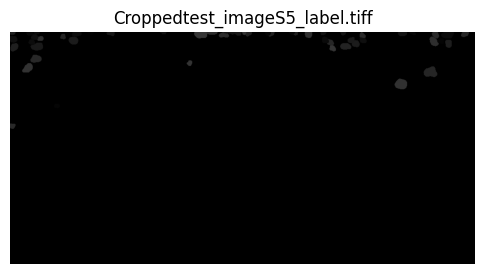

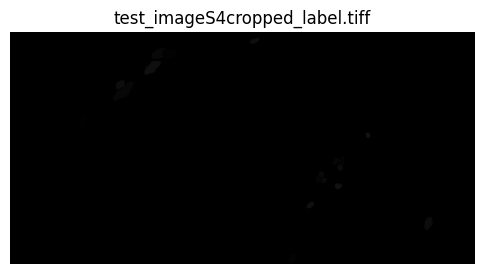

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

output_dir = r"D:\CellSeg\output"

# List all TIFF files
tiff_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.tif') or f.lower().endswith('.tiff')]

for filename in tiff_files:
    path = os.path.join(output_dir, filename)
    img = Image.open(path)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')  # Use 'gray' for segmentation masks
    plt.title(filename)
    plt.axis('off')
    plt.show()
